# Score Scale Inconsistency

Scoring distribution per judge model

Judge model candidate:
- GPT-4o-Aug
- o4-mini
- Claude Sonnet 4.5
- Gemini 3 Pro
- Llama-3.1-8B-Instruct
- Llama-3.1-70B-Instruct
- Qwen3-4B-Instruct
- Qwen3-4B-Thinking
- Prometheus 2 7B
- JudgeLRM 7B

In [6]:
import sys
sys.path.insert(0, '/workspace/Materials_RL')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import jsonlines
from judge_agreement import load_judge_scores_as_df, load_expert_scores, extract_json_from_text, is_judgelrm_file

# File mapping for each judge model
judge_files = {
    'GPT-4o-Aug': 'outputs/human_eval/mixed-10test-0117_gpt-4o-2024-08-06_judge_1shot.jsonl',
    'o4-mini': 'outputs/human_eval/mixed-10test-0117_o4-mini_judge_1shot.jsonl',
    'Claude Sonnet 4.5': 'outputs/human_eval/mixed-10test-0117_claude-sonnet-4.5_judge_1shot.jsonl',
    'Gemini 3 Pro': 'outputs/human_eval/mixed-10test-0117_gemini-3-pro-preview_judge_1shot.jsonl',
    'Llama-3.1-8B': 'outputs/human_eval/mixed-10test-0117_Llama-3.1-8B-Instruct_judge_1shot.jsonl',
    'Llama-3.3-70B': 'outputs/human_eval/mixed-10test-0117_Llama-3.3-70B-Instruct_judge_1shot.jsonl',
    'Qwen3-4B-Instruct': 'outputs/human_eval/mixed-10test-0117_Qwen3-4B-Instruct-2507_judge_1shot.jsonl',
    'Qwen3-4B-Thinking': 'outputs/human_eval/mixed-10test-0117_Qwen3-4B-Thinking-2507_judge_1shot.jsonl',
    'Prometheus-7B': 'outputs/human_eval/mixed-10test-0117_prometheus-7b-v2.0_judge_1shot.jsonl',
    'JudgeLRM-7B': 'outputs/human_eval/mixed-10test-0117_JudgeLRM-7B_judge_judgelrm.jsonl',
}

# Model categories for coloring
API_MODELS = ['GPT-4o-Aug', 'o4-mini', 'Claude Sonnet 4.5', 'Gemini 3 Pro']
OPENWEIGHT_MODELS = ['Llama-3.1-8B', 'Llama-3.3-70B', 'Qwen3-4B-Instruct', 'Qwen3-4B-Thinking']
JUDGE_MODELS = ['Prometheus-7B', 'JudgeLRM-7B']

def get_category_color(model):
    if model in API_MODELS:
        return '#2E86AB'
    elif model in OPENWEIGHT_MODELS:
        return '#28A745'
    elif model in JUDGE_MODELS:
        return '#E94F37'
    elif model == 'Expert (High-Conf)':
        return '#333333'
    elif model == 'Expert (Full)':
        return '#666666'
    else:
        return '#999999'

# Low confidence evaluators to exclude for high-conf group
low_conf_evaluators = ['김윤서', '이치훈', '전동원', '홍지훈', '배지수']

# Load expert scores for both groups
expert_csv = '/workspace/Materials_RL/outputs/human_eval/0117-2차평가-예측평가.csv'
label_jsonl = '/workspace/Materials_RL/outputs/human_eval/mixed-10test-0117.jsonl'

df_expert_full = load_expert_scores(expert_csv, label_jsonl=label_jsonl, id_column='Paper ID')
df_expert_high = load_expert_scores(expert_csv, label_jsonl=label_jsonl, id_column='Paper ID', 
                                     remove_evaluators=low_conf_evaluators)

print(f"Expert (Full): {len(df_expert_full)} samples, Mean: {df_expert_full['Overall Score AVG'].mean():.2f}")
print(f"Expert (High-Conf): {len(df_expert_high)} samples, Mean: {df_expert_high['Overall Score AVG'].mean():.2f}")

Expert (Full): 20 samples, Mean: 3.32
Expert (High-Conf): 20 samples, Mean: 4.21


In [7]:
# Load all judge scores and compute statistics
judge_scores = {}
score_stats = []

for model_name, judge_path in judge_files.items():
    full_path = f'/workspace/Materials_RL/{judge_path}'
    df = load_judge_scores_as_df(full_path, combine_id_model=True)
    
    # Get overall score column
    if 'Overall' in df.columns:
        scores = df['Overall'].dropna().values
    elif 'Overall Score AVG' in df.columns:
        scores = df['Overall Score AVG'].dropna().values
    else:
        continue
    
    judge_scores[model_name] = scores
    
    score_stats.append({
        'Model': model_name,
        'N': len(scores),
        'Mean': np.mean(scores),
        'Std': np.std(scores),
        'Min': np.min(scores),
        'Max': np.max(scores),
        'Median': np.median(scores),
        'Skewness': stats.skew(scores) if len(scores) > 2 else np.nan,
    })

# Add Expert (High-Conf) scores
expert_high_scores = df_expert_high['Overall Score AVG'].dropna().values
judge_scores['Expert (High-Conf)'] = expert_high_scores
score_stats.append({
    'Model': 'Expert (High-Conf)',
    'N': len(expert_high_scores),
    'Mean': np.mean(expert_high_scores),
    'Std': np.std(expert_high_scores),
    'Min': np.min(expert_high_scores),
    'Max': np.max(expert_high_scores),
    'Median': np.median(expert_high_scores),
    'Skewness': stats.skew(expert_high_scores),
})

# Add Expert (Full) scores
expert_full_scores = df_expert_full['Overall Score AVG'].dropna().values
judge_scores['Expert (Full)'] = expert_full_scores
score_stats.append({
    'Model': 'Expert (Full)',
    'N': len(expert_full_scores),
    'Mean': np.mean(expert_full_scores),
    'Std': np.std(expert_full_scores),
    'Min': np.min(expert_full_scores),
    'Max': np.max(expert_full_scores),
    'Median': np.median(expert_full_scores),
    'Skewness': stats.skew(expert_full_scores),
})

df_stats = pd.DataFrame(score_stats)
df_stats.set_index('Model', inplace=True)
df_stats.round(3)

,N,Mean,Std,Min,Max,Median,Skewness
Model,,,,,,,
GPT-4o-Aug,20,3.833,0.530,2.800,4.570,4.000,-0.462
o4-mini,20,3.170,0.614,2.000,4.000,3.400,-0.456
Claude Sonnet 4.5,20,3.105,0.388,2.500,3.800,3.000,-0.156
Gemini 3 Pro,20,2.975,0.766,1.500,4.500,3.000,-0.083
Llama-3.1-8B,19,4.205,0.295,3.300,4.600,4.200,-1.101
Llama-3.3-70B,20,4.310,0.226,4.000,4.600,4.300,0.059
Qwen3-4B-Instruct,20,3.267,0.552,2.000,4.200,3.250,-0.308
Qwen3-4B-Thinking,20,3.290,0.641,2.000,4.600,3.350,-0.082
Prometheus-7B,16,4.219,0.661,3.500,5.000,4.500,-0.027


/tmp/ipykernel_2777317/759938771.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, patch_artist=True, labels=models_order)


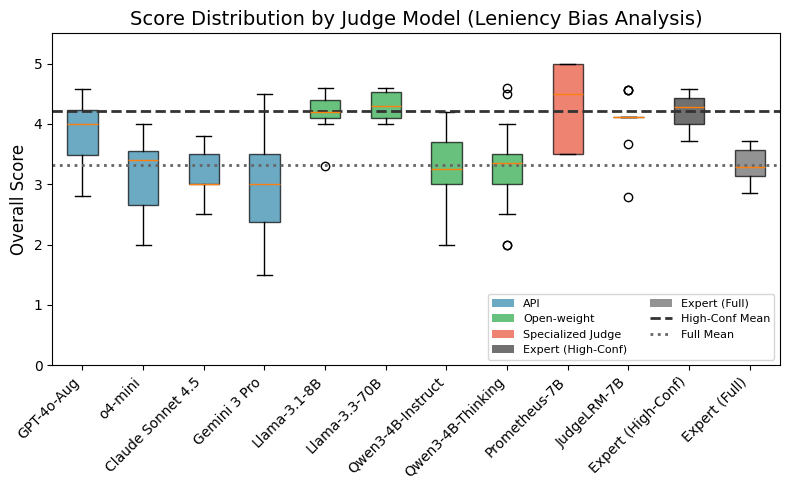

In [18]:
# Visualization 1: Box plot of score distributions
fig, ax = plt.subplots(figsize=(8, 5))

# Prepare data for box plot (include both expert groups)
models_order = list(judge_files.keys()) + ['Expert (High-Conf)', 'Expert (Full)']
box_data = [judge_scores[m] for m in models_order]
colors = [get_category_color(m) for m in models_order]

bp = ax.boxplot(box_data, patch_artist=True, labels=models_order)

# Color the boxes
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Add expert mean lines
expert_high_mean = np.mean(judge_scores['Expert (High-Conf)'])
expert_full_mean = np.mean(judge_scores['Expert (Full)'])
ax.axhline(y=expert_high_mean, color='#333333', linestyle='--', linewidth=2, 
           label=f'Expert High-Conf Mean ({expert_high_mean:.2f})')
ax.axhline(y=expert_full_mean, color='#666666', linestyle=':', linewidth=2, 
           label=f'Expert Full Mean ({expert_full_mean:.2f})')

ax.set_ylabel('Overall Score', fontsize=12)
ax.set_title('Score Distribution by Judge Model (Leniency Bias Analysis)', fontsize=14)
ax.set_xticklabels(models_order, rotation=45, ha='right', fontsize=10)
ax.set_ylim(0, 5.5)

# Add category legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
    Patch(facecolor='#2E86AB', alpha=0.7, label='API'),
    Patch(facecolor='#28A745', alpha=0.7, label='Open-weight'),
    Patch(facecolor='#E94F37', alpha=0.7, label='Specialized Judge'),
    Patch(facecolor='#333333', alpha=0.7, label='Expert (High-Conf)'),
    Patch(facecolor='#666666', alpha=0.7, label='Expert (Full)'),
    Line2D([0], [0], color='#333333', linestyle='--', linewidth=2, label=f'High-Conf Mean'),
    Line2D([0], [0], color='#666666', linestyle=':', linewidth=2, label=f'Full Mean'),
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=8, ncol=2)

plt.tight_layout()
plt.savefig('/workspace/Materials_RL/analysis/score_distribution_boxplot.png', dpi=150, bbox_inches='tight')
plt.show()

/tmp/ipykernel_2777317/1982270492.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=45, ha='right', fontsize=9)
/tmp/ipykernel_2777317/1982270492.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=45, ha='right', fontsize=9)


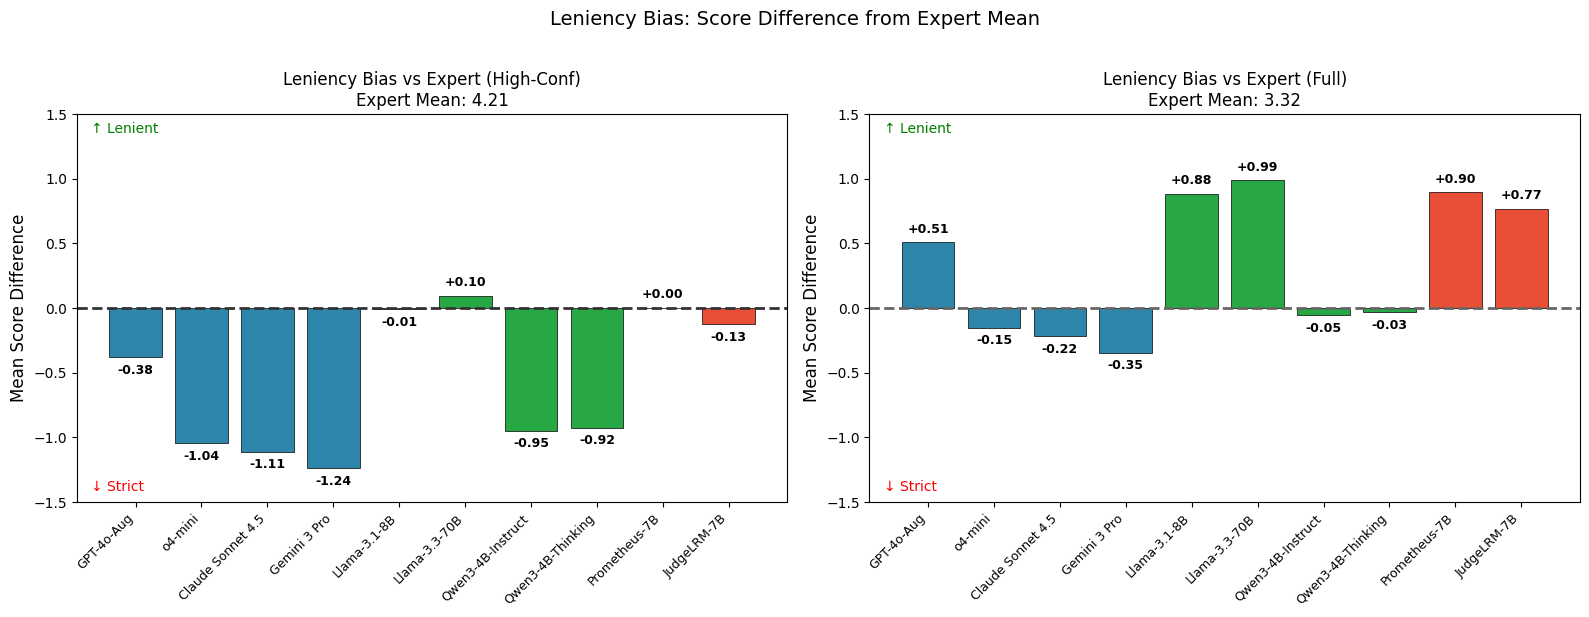

In [10]:
# Visualization 2: Leniency Bias (Mean difference from both Expert groups)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

models = list(judge_files.keys())
expert_high_mean = df_stats.loc['Expert (High-Conf)', 'Mean']
expert_full_mean = df_stats.loc['Expert (Full)', 'Mean']

# Left: vs High-Conf Expert
ax = axes[0]
mean_diffs_high = [df_stats.loc[m, 'Mean'] - expert_high_mean for m in models]
colors = [get_category_color(m) for m in models]

bars = ax.bar(models, mean_diffs_high, color=colors, edgecolor='black', linewidth=0.5)
for bar, diff in zip(bars, mean_diffs_high):
    height = bar.get_height()
    va = 'bottom' if height >= 0 else 'top'
    offset = 0.05 if height >= 0 else -0.05
    ax.annotate(f'{diff:+.2f}', xy=(bar.get_x() + bar.get_width()/2, height + offset),
                ha='center', va=va, fontsize=9, fontweight='bold')

ax.axhline(y=0, color='#333333', linestyle='--', linewidth=2)
ax.set_ylabel('Mean Score Difference', fontsize=12)
ax.set_title(f'Leniency Bias vs Expert (High-Conf)\nExpert Mean: {expert_high_mean:.2f}', fontsize=12)
ax.set_xticklabels(models, rotation=45, ha='right', fontsize=9)
ax.set_ylim(-1.5, 1.5)

# Right: vs Full Expert
ax = axes[1]
mean_diffs_full = [df_stats.loc[m, 'Mean'] - expert_full_mean for m in models]

bars = ax.bar(models, mean_diffs_full, color=colors, edgecolor='black', linewidth=0.5)
for bar, diff in zip(bars, mean_diffs_full):
    height = bar.get_height()
    va = 'bottom' if height >= 0 else 'top'
    offset = 0.05 if height >= 0 else -0.05
    ax.annotate(f'{diff:+.2f}', xy=(bar.get_x() + bar.get_width()/2, height + offset),
                ha='center', va=va, fontsize=9, fontweight='bold')

ax.axhline(y=0, color='#666666', linestyle='--', linewidth=2)
ax.set_ylabel('Mean Score Difference', fontsize=12)
ax.set_title(f'Leniency Bias vs Expert (Full)\nExpert Mean: {expert_full_mean:.2f}', fontsize=12)
ax.set_xticklabels(models, rotation=45, ha='right', fontsize=9)
ax.set_ylim(-1.5, 1.5)

# Common annotations
for ax in axes:
    ax.text(0.02, 0.98, '↑ Lenient', transform=ax.transAxes, fontsize=10, va='top', color='green')
    ax.text(0.02, 0.02, '↓ Strict', transform=ax.transAxes, fontsize=10, va='bottom', color='red')

plt.suptitle('Leniency Bias: Score Difference from Expert Mean', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('/workspace/Materials_RL/analysis/leniency_bias.png', dpi=150, bbox_inches='tight')
plt.show()

# Length Bias Analysis

In [11]:
# Load predictions and calculate lengths
def load_judge_data_with_lengths(filepath):
    """Load judge results with prediction lengths."""
    records = []
    is_judgelrm = is_judgelrm_file(filepath)
    
    with jsonlines.open(filepath) as reader:
        for item in reader:
            sample_id = item.get('id')
            model = item.get('model', '')
            prediction = item.get('prediction', '')
            judge_result = item.get('judge_result', '')
            
            # Extract score
            extracted = extract_json_from_text(judge_result, is_judgelrm=is_judgelrm)
            if extracted is None:
                continue
            
            # Get overall score
            if 'overall_score' in extracted:
                score = extracted['overall_score']
            else:
                continue
            
            # Calculate prediction length (character count)
            pred_length = len(prediction)
            
            records.append({
                'id': f"{sample_id}-{model}",
                'prediction_length': pred_length,
                'score': score
            })
    
    return pd.DataFrame(records)

# Load data for all judge models
length_data = {}
for model_name, judge_path in judge_files.items():
    full_path = f'/workspace/Materials_RL/{judge_path}'
    df = load_judge_data_with_lengths(full_path)
    if len(df) > 0:
        length_data[model_name] = df
        print(f"{model_name}: {len(df)} samples, length range: {df['prediction_length'].min()}-{df['prediction_length'].max()}")

GPT-4o-Aug: 20 samples, length range: 4147-14205
o4-mini: 20 samples, length range: 4147-14205
Claude Sonnet 4.5: 20 samples, length range: 4147-14205
Gemini 3 Pro: 20 samples, length range: 4147-14205
Llama-3.1-8B: 19 samples, length range: 4147-14205
Llama-3.3-70B: 20 samples, length range: 4147-14205
Qwen3-4B-Instruct: 20 samples, length range: 4147-14205
Qwen3-4B-Thinking: 20 samples, length range: 4147-14205
Prometheus-7B: 16 samples, length range: 4190-14205
JudgeLRM-7B: 20 samples, length range: 4147-14205


In [12]:
# Scale lengths to 1-100 and calculate correlations
def scale_to_100(values):
    """Scale values to 1-100 range."""
    min_val, max_val = np.min(values), np.max(values)
    if max_val == min_val:
        return np.ones_like(values) * 50
    return 1 + (values - min_val) / (max_val - min_val) * 99

# Calculate length-score correlations for each judge
length_correlations = []

for model_name, df in length_data.items():
    lengths = df['prediction_length'].values
    scores = df['score'].values
    
    # Scale lengths to 1-100
    scaled_lengths = scale_to_100(lengths)
    df['scaled_length'] = scaled_lengths
    
    # Calculate correlations
    if len(lengths) >= 3:
        pearson_r, pearson_p = stats.pearsonr(scaled_lengths, scores)
        spearman_r, spearman_p = stats.spearmanr(scaled_lengths, scores)
    else:
        pearson_r, pearson_p = np.nan, np.nan
        spearman_r, spearman_p = np.nan, np.nan
    
    length_correlations.append({
        'Model': model_name,
        'N': len(df),
        'Pearson r': pearson_r,
        'Pearson p': pearson_p,
        'Spearman r': spearman_r,
        'Spearman p': spearman_p,
        'Length Bias': 'Yes' if abs(pearson_r) > 0.3 and pearson_p < 0.05 else 'No'
    })

df_length_corr = pd.DataFrame(length_correlations)
df_length_corr.set_index('Model', inplace=True)
df_length_corr.round(3)

,N,Pearson r,Pearson p,Spearman r,Spearman p,Length Bias
Model,,,,,,
GPT-4o-Aug,20,0.453,0.045,0.498,0.026,Yes
o4-mini,20,0.364,0.114,0.349,0.131,No
Claude Sonnet 4.5,20,0.128,0.592,0.147,0.536,No
Gemini 3 Pro,20,0.310,0.184,0.340,0.142,No
Llama-3.1-8B,19,0.459,0.048,0.577,0.010,Yes
Llama-3.3-70B,20,0.516,0.020,0.486,0.030,Yes
Qwen3-4B-Instruct,20,0.178,0.453,0.255,0.278,No
Qwen3-4B-Thinking,20,0.316,0.174,0.105,0.658,No
Prometheus-7B,16,-0.154,0.568,-0.036,0.894,No


/tmp/ipykernel_2777317/2486204598.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=45, ha='right', fontsize=10)


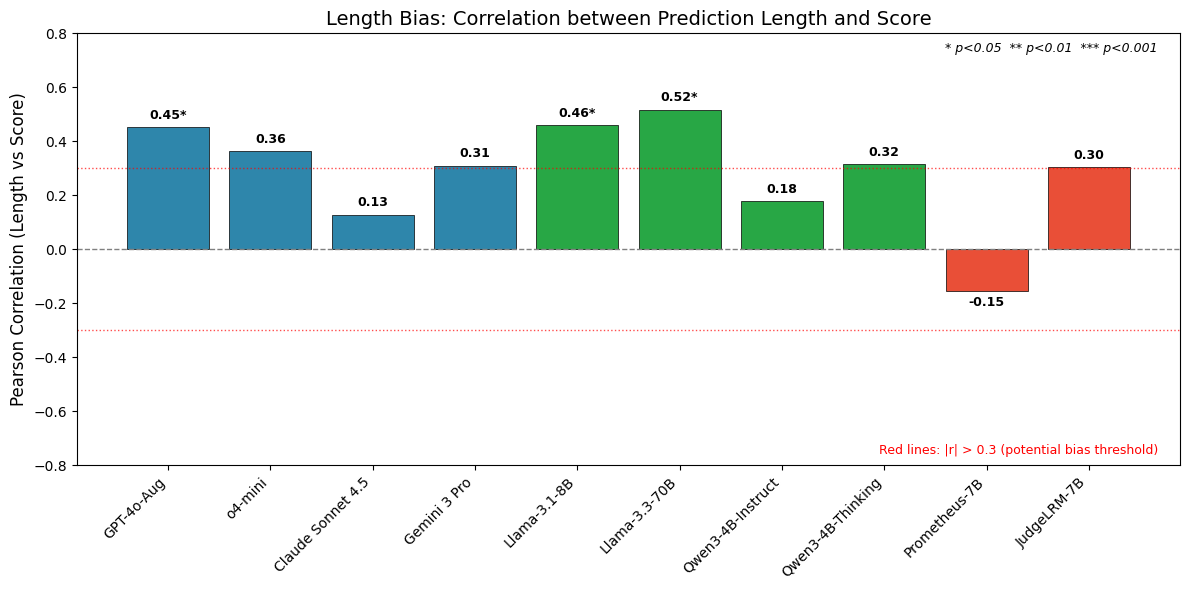

In [13]:
# Visualization 3: Length Bias Correlation Bar Chart
fig, ax = plt.subplots(figsize=(12, 6))

models = list(length_data.keys())
correlations = [df_length_corr.loc[m, 'Pearson r'] for m in models]
p_values = [df_length_corr.loc[m, 'Pearson p'] for m in models]
colors = [get_category_color(m) for m in models]

bars = ax.bar(models, correlations, color=colors, edgecolor='black', linewidth=0.5)

# Add significance markers
for i, (bar, p) in enumerate(zip(bars, p_values)):
    height = bar.get_height()
    if not np.isnan(p):
        sig_marker = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
        va = 'bottom' if height >= 0 else 'top'
        offset = 0.02 if height >= 0 else -0.02
        ax.annotate(f'{height:.2f}{sig_marker}', 
                    xy=(bar.get_x() + bar.get_width()/2, height + offset),
                    ha='center', va=va, fontsize=9, fontweight='bold')

ax.axhline(y=0, color='gray', linestyle='--', linewidth=1)
ax.axhline(y=0.3, color='red', linestyle=':', linewidth=1, alpha=0.7)
ax.axhline(y=-0.3, color='red', linestyle=':', linewidth=1, alpha=0.7)

ax.set_ylabel('Pearson Correlation (Length vs Score)', fontsize=12)
ax.set_title('Length Bias: Correlation between Prediction Length and Score', fontsize=14)
ax.set_xticklabels(models, rotation=45, ha='right', fontsize=10)
ax.set_ylim(-0.8, 0.8)

# Add legend for significance
ax.text(0.98, 0.98, '* p<0.05  ** p<0.01  *** p<0.001', transform=ax.transAxes, 
        fontsize=9, va='top', ha='right', style='italic')
ax.text(0.98, 0.02, 'Red lines: |r| > 0.3 (potential bias threshold)', transform=ax.transAxes, 
        fontsize=9, va='bottom', ha='right', color='red')

plt.tight_layout()
plt.savefig('/workspace/Materials_RL/analysis/length_bias_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

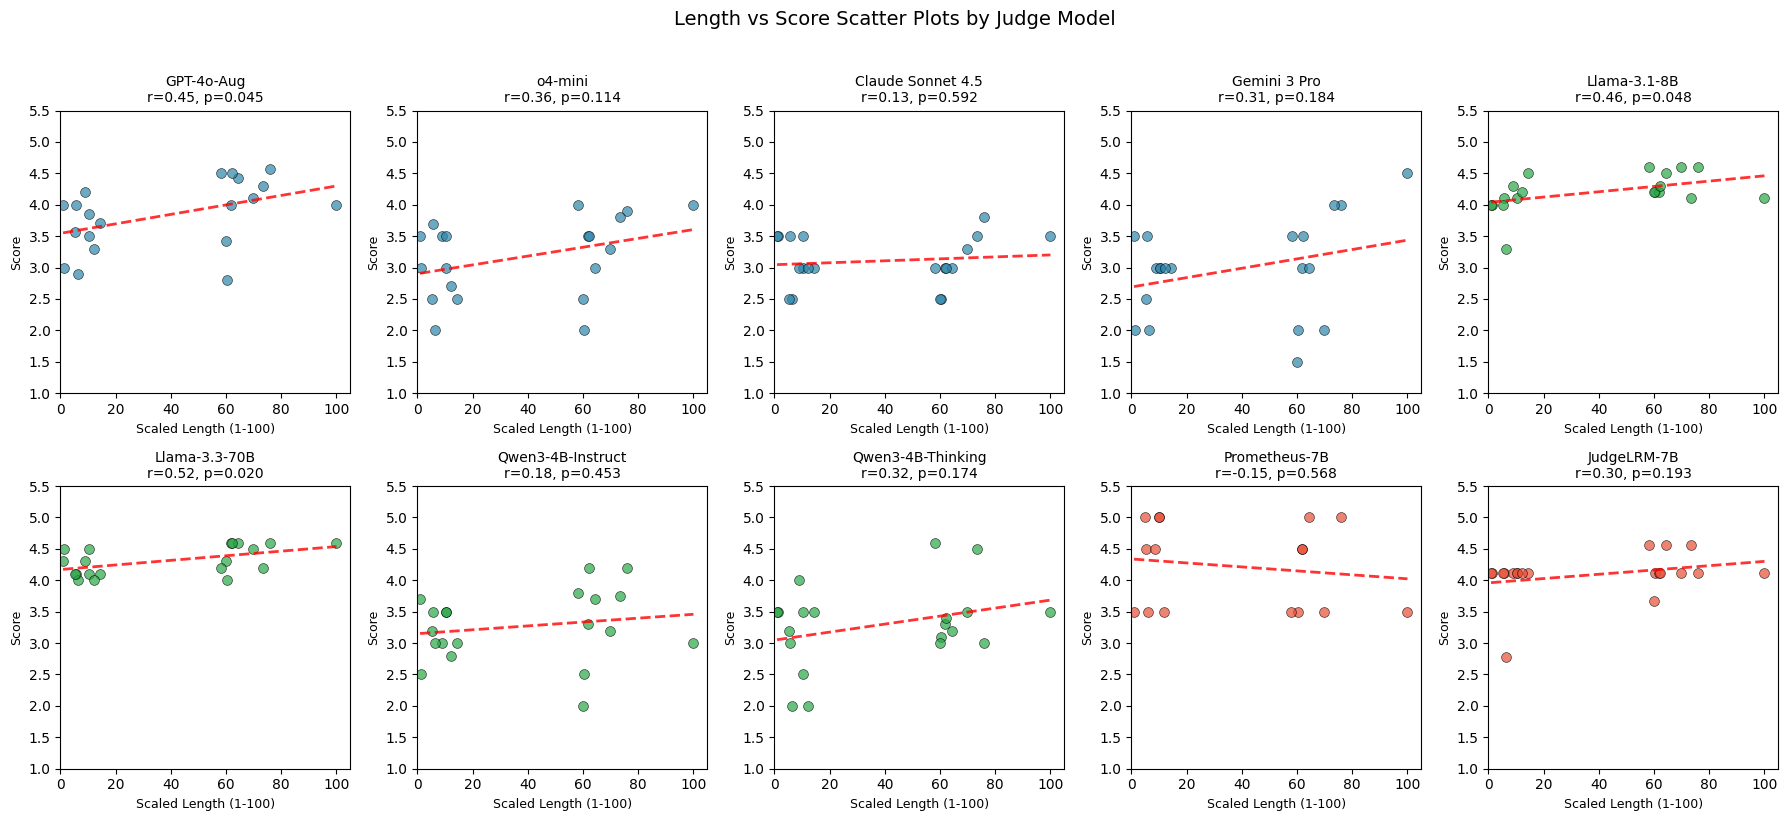

In [14]:
# Visualization 4: Scatter plots for Length vs Score (selected models)
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.flatten()

for idx, (model_name, df) in enumerate(length_data.items()):
    ax = axes[idx]
    color = get_category_color(model_name)
    
    ax.scatter(df['scaled_length'], df['score'], c=color, alpha=0.7, s=50, edgecolor='black', linewidth=0.5)
    
    # Add regression line
    if len(df) >= 3:
        z = np.polyfit(df['scaled_length'], df['score'], 1)
        p = np.poly1d(z)
        x_line = np.linspace(df['scaled_length'].min(), df['scaled_length'].max(), 100)
        ax.plot(x_line, p(x_line), 'r--', linewidth=2, alpha=0.8)
    
    # Get correlation
    r = df_length_corr.loc[model_name, 'Pearson r']
    p_val = df_length_corr.loc[model_name, 'Pearson p']
    
    ax.set_title(f'{model_name}\nr={r:.2f}, p={p_val:.3f}', fontsize=10)
    ax.set_xlabel('Scaled Length (1-100)', fontsize=9)
    ax.set_ylabel('Score', fontsize=9)
    ax.set_xlim(0, 105)
    ax.set_ylim(1, 5.5)

plt.suptitle('Length vs Score Scatter Plots by Judge Model', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('/workspace/Materials_RL/analysis/length_bias_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary

In [15]:
# Summary: Combined Bias Analysis
summary_data = []
expert_high_mean = df_stats.loc['Expert (High-Conf)', 'Mean']
expert_full_mean = df_stats.loc['Expert (Full)', 'Mean']

for model in judge_files.keys():
    # Leniency bias vs High-Conf
    mean_score = df_stats.loc[model, 'Mean']
    leniency_high = mean_score - expert_high_mean
    leniency_full = mean_score - expert_full_mean
    
    def get_status(diff):
        return 'Lenient' if diff > 0.3 else 'Strict' if diff < -0.3 else 'Neutral'
    
    # Length bias
    if model in df_length_corr.index:
        length_r = df_length_corr.loc[model, 'Pearson r']
        length_bias = df_length_corr.loc[model, 'Length Bias']
    else:
        length_r, length_bias = np.nan, 'N/A'
    
    # Category
    if model in API_MODELS:
        category = 'API'
    elif model in OPENWEIGHT_MODELS:
        category = 'Open-weight'
    else:
        category = 'Specialized'
    
    summary_data.append({
        'Model': model,
        'Category': category,
        'Mean Score': round(mean_score, 2),
        'vs High-Conf': f'{leniency_high:+.2f}',
        'Status (High)': get_status(leniency_high),
        'vs Full': f'{leniency_full:+.2f}',
        'Status (Full)': get_status(leniency_full),
        'Length r': round(length_r, 2) if not np.isnan(length_r) else 'N/A',
        'Length Bias': length_bias,
    })

df_summary = pd.DataFrame(summary_data)
df_summary.set_index('Model', inplace=True)
df_summary

,Category,Mean Score,vs High-Conf,Status (High),vs Full,Status (Full),Length r,Length Bias
Model,,,,,,,,
GPT-4o-Aug,API,3.83,-0.38,Strict,+0.51,Lenient,0.45,Yes
o4-mini,API,3.17,-1.04,Strict,-0.15,Neutral,0.36,No
Claude Sonnet 4.5,API,3.10,-1.11,Strict,-0.22,Neutral,0.13,No
Gemini 3 Pro,API,2.98,-1.24,Strict,-0.35,Strict,0.31,No
Llama-3.1-8B,Open-weight,4.21,-0.01,Neutral,+0.88,Lenient,0.46,Yes
Llama-3.3-70B,Open-weight,4.31,+0.10,Neutral,+0.99,Lenient,0.52,Yes
Qwen3-4B-Instruct,Open-weight,3.27,-0.95,Strict,-0.05,Neutral,0.18,No
Qwen3-4B-Thinking,Open-weight,3.29,-0.92,Strict,-0.03,Neutral,0.32,No
Prometheus-7B,Specialized,4.22,+0.00,Neutral,+0.90,Lenient,-0.15,No


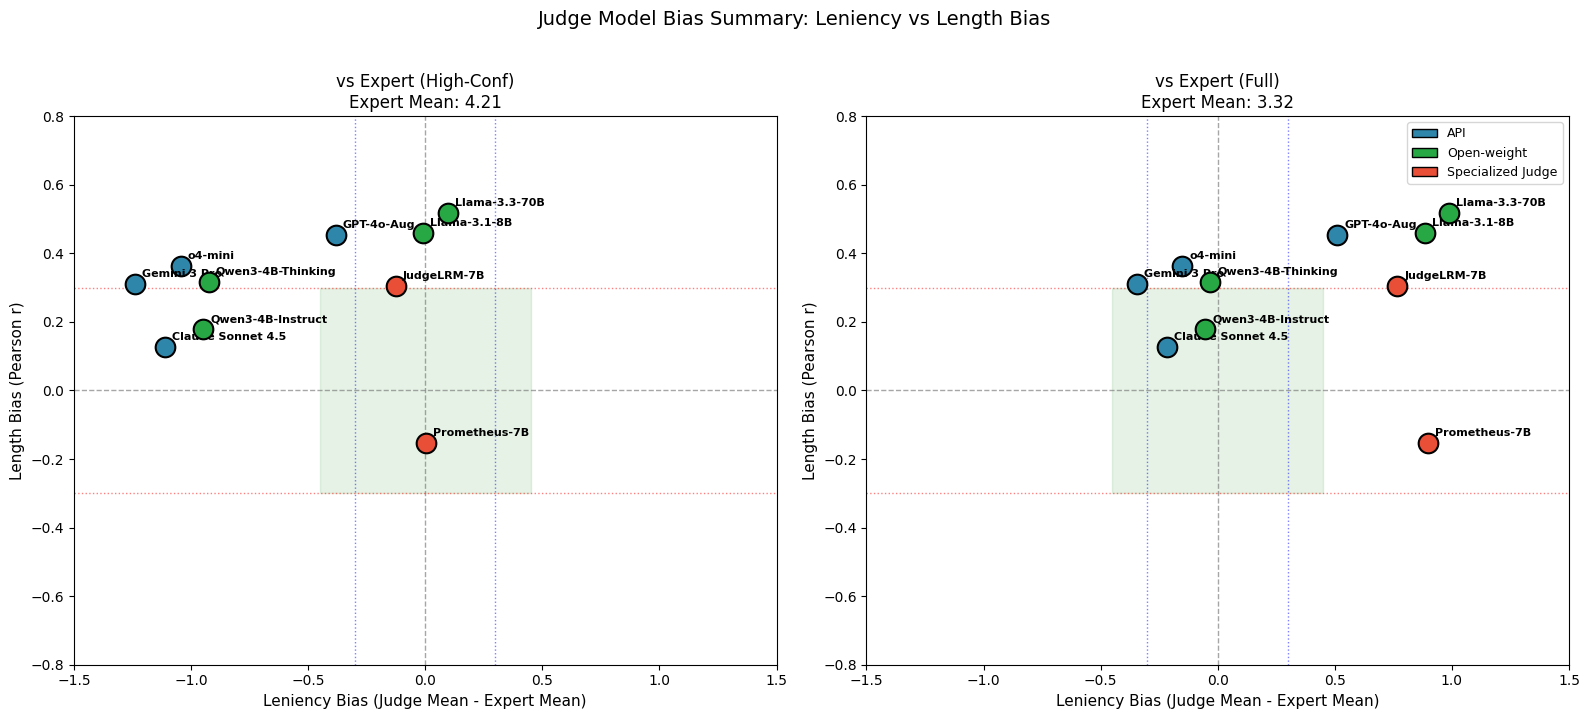

In [16]:
# Visualization 5: Combined Bias Summary (2D scatter - both expert groups)
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

models = list(judge_files.keys())
expert_high_mean = df_stats.loc['Expert (High-Conf)', 'Mean']
expert_full_mean = df_stats.loc['Expert (Full)', 'Mean']

for ax, (expert_name, expert_mean) in zip(axes, [('High-Conf', expert_high_mean), ('Full', expert_full_mean)]):
    leniency_vals = [df_stats.loc[m, 'Mean'] - expert_mean for m in models]
    length_vals = [df_length_corr.loc[m, 'Pearson r'] if m in df_length_corr.index else 0 for m in models]
    colors = [get_category_color(m) for m in models]
    
    # Plot scatter
    for model, x, y, c in zip(models, leniency_vals, length_vals, colors):
        ax.scatter(x, y, c=c, s=200, edgecolor='black', linewidth=1.5, zorder=3)
        ax.annotate(model, (x, y), xytext=(5, 5), textcoords='offset points', fontsize=8, fontweight='bold')
    
    # Add reference lines
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
    ax.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
    
    # Add bias threshold zones
    ax.axhline(y=0.3, color='red', linestyle=':', linewidth=1, alpha=0.5)
    ax.axhline(y=-0.3, color='red', linestyle=':', linewidth=1, alpha=0.5)
    ax.axvline(x=0.3, color='blue', linestyle=':', linewidth=1, alpha=0.5)
    ax.axvline(x=-0.3, color='blue', linestyle=':', linewidth=1, alpha=0.5)
    
    # Shade the ideal zone
    ax.axhspan(-0.3, 0.3, xmin=0.35, xmax=0.65, alpha=0.1, color='green')
    
    ax.set_xlabel('Leniency Bias (Judge Mean - Expert Mean)', fontsize=11)
    ax.set_ylabel('Length Bias (Pearson r)', fontsize=11)
    ax.set_title(f'vs Expert ({expert_name})\nExpert Mean: {expert_mean:.2f}', fontsize=12)
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-0.8, 0.8)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2E86AB', edgecolor='black', label='API'),
    Patch(facecolor='#28A745', edgecolor='black', label='Open-weight'),
    Patch(facecolor='#E94F37', edgecolor='black', label='Specialized Judge'),
]
axes[1].legend(handles=legend_elements, loc='upper right', fontsize=9)

plt.suptitle('Judge Model Bias Summary: Leniency vs Length Bias', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('/workspace/Materials_RL/analysis/bias_summary_2d.png', dpi=150, bbox_inches='tight')
plt.show()